# Deep Hedging of Options
Aadhar Agarwal

# The problem

- Two tradable assets with values $S^1$ and $S^2$. Example: two stocks in the same stock index (e.g. two components of the SP500).

- We want to delta-hedge an option with payoff $g(S^1, S^2)$ over the time grid $t_j = \frac{j \Delta t}{N}$, for $j=0, \ldots, N-1$. We will consider an at-the-money (ATM) call on the product:
  
  $$ g(S^1, S^2) = \left(\frac{S^1 S^2}{S^1_0 S^2_0} - 1\right)^+ $$

- The hedging portfolio now has a delta component $\delta^i$ in each of the two assets:
  
  $$ V_t = V^0 + \delta^1_t S^1_t + \delta^2_t S^2_t = \left( V_t - \sum_{k=1}^2 \delta^k_t S^k_t \right) + \sum_{k=1}^2 \delta^k_t S^k_t. $$

  The evolution in time of this self-financing portfolio is still made of the variation of the cash part (with interest rate $r$) plus the variation of the delta part:
  
  $$ V_{t_{j+1}} = V_{t_j} + r\left(V_{t_j} - \sum_{k=1}^2 \delta^k_{t_j} S^k_{t_j}\right)\Delta t + \sum_{k=1}^2 \delta^k_{t_j} (S^k_{t_{j+1}} - S^k_{t_j}), \quad j=0,\ldots,N-1 $$

# Dynamical model

A two-dimensional log-normal model:

$$
\begin{cases}
    \log S^1_{t_{j+1}} = \log S^1_{t_j} + \mu_1 \Delta t + \sigma_1 \sqrt{\Delta t} G^1_j, \\
    \log S^2_{t_{j+1}} = \log S^2_{t_j} + \mu_2 \Delta t + \sigma_2 \sqrt{\Delta t} G^2_j,
\end{cases}
$$

where each asset evolves in time with its own drift parameter $\mu_k$ and volatility parameter $\sigma_k$. For every $j$, the two increments $(G^1_j, G^2_j)$ form a standard Gaussian vector in $\mathbb{R}^2$ with zero mean and correlation parameter $\rho$, that is

$$
G_j :=
\begin{pmatrix}
    G^1_j \\
    G^2_j
\end{pmatrix}
\sim \mathcal{N}_{R^2}(\mathbf{0}, C), \text{ where } C = \text{covariance matrix} =
\begin{pmatrix}
    1 & \rho \\
    \rho & 1
\end{pmatrix}
$$

The vector increments $(G_0, G_1, \ldots, G_{N-1})$ form an independent sequence.

# Additional parameter values

$$
T = 1 \text{ year}, \quad N = 100, \quad \mu_1 = 0.025, \quad \mu_2 = -0.01, \quad \sigma_1 = 0.22, \quad \sigma_2 = 0.3, \quad \rho = 0.5, \quad r = 0.04.
$$

# Approach

- We aim at learning the appropriate two-dimensional hedging strategy

  $$ (\delta^1_t, \delta^2_t) $$

over the time grid $\{t_j\}$ using a deep hedging approach: we parameterize both deltas with neural networks

$$ \delta^1_t = h^1_j(S^1_{t_j}, S^2_{t_j}), $$
$$ \delta^2_t = h^2_j(S^1_{t_j}, S^2_{t_j}), $$

where each NN $h^k_j$ is a function of the values $(S^1_{t_j}, S^2_{t_j})$ of the two assets at current time $t_j$.  
We also parameterize the initial option price (or option premium) with a NN $\pi(S^1_0, S^2_0)$.

- As in the 1-dim application we have considered in session 6, the criterion to be minimized is the square of the final hedging error:

  hedging error = option payoff - (option premium + contribution from hedging)

along the trajectories in the training set.





# Your task

1. Construct a training set of \( $N_{\text{train}}$ \) two-dimensional trajectories

   $$
   \left( S^{1,i}_{t_j}, S^{2,i}_{t_j} \right)^{1 \leq i \leq N_{\text{train}}}_{0 \leq j \leq N}
   $$

   for the two assets under the log-normal dynamical model above. This will require to simulate a sequence of i.i.d. Gaussian vectors

   $$
   \begin{pmatrix}
   G^1_j \\
   G^2_j
   \end{pmatrix}
   $$

   with correlation parameter \( $\rho$ \).

2. Construct and train a deep learning model tackling the deep hedging problem described above. You are free to choose the architecture of the neural networks entering into the model.

3. Assess and display the performance of the resulting model. Similarly to what we did in session 6, this can be done by providing some statistics of the final hedging error (mean, std, histogram), and displaying the profiles of the delta functions yield by the deep hedging model.


In [1]:
# my kernel
import numpy as np
import tensorflow as tf
import scipy.stats as sps

from keras.layers import Input, Dense, Concatenate, Subtract, Multiply, Lambda, Add

from keras.models import Model
from keras import initializers
import keras.backend as K_backend

import matplotlib.pyplot as plt

import copy

# Part 1. Simulation of the Stohastic Processes

In [2]:
# Parameters
N = 100 # number of time steps
S0 = [1, 2] # initial value of the assets S0_1 and S0_2 (in Euros)

T = 1
mu1 = 0.025
mu2 = -0.01
sigma1 = 0.22
sigma2 = 0.3
rho = 0.5
Delta_T = T / N
r = 0.04
r_dt = r * Delta_T 

In order to simulate 2 correlated stohastic processes we use Cholesky decomposition. 

### Cholesky Decomposition

Cholesky decomposition is a method used to decompose a symmetric, positive-definite matrix into a product of a lower triangular matrix and its conjugate transpose. For the covariance matrix $C$, Cholesky decomposition produces a matrix $L$ such that:

$$C = LL^T$$

Here, $L$ is a lower triangular matrix. This decomposition is particularly useful for generating correlated random variables from independent random variables.

### Generating Correlated Random Variables

To simulate correlated asset prices, we start by generating random variables that are normally distributed. Suppose we generate a vector \(Z\) of independent standard normal random variables:

$$Z = \begin{pmatrix} z_1 \\ z_2 \end{pmatrix}$$

where $z_1$ and $z_2$ are independent draws from a standard normal distribution $N(0,1)$.

We can then apply the Cholesky decomposition $L$ to transform $Z$ into a new vector $G$ of correlated random variables:

$$G = LZ$$

This operation introduces the desired correlation between $z_1$ and $z_2$, as specified by the covariance matrix $C$, resulting in $G$ which respects the correlation $\rho$.

### Simulating Log Increments

For each asset, we simulate log increments over time. The log increment for asset $i$ at time $t$ can be modeled as:

$$\Delta \log S_i(t) = \mu_i \Delta t + \sigma_i \sqrt{\Delta t} \cdot G_i(t)$$

where:

- $\Delta \log S_i(t)$ is the log increment of asset $i$ at time $t$,
- $\mu_i$ is the drift coefficient of asset $i$,
- $\sigma_i$ is the volatility of asset $i$,
- $\Delta t$ is the time increment,
- $G_i(t)$ is the $i$th element of vector $G$ at time $t$, representing the correlated random shock to asset $i$'s return.

### Constructing Asset Price Trajectories

Starting from initial asset prices $S_{i,0}$, we can construct the price trajectories by exponentiating the cumulative sum of log increments:

$$S_i(t) = S_{i,0} \exp\left(\sum \Delta \log S_i(t)\right)$$

This formula gives us the simulated price of asset $i$ at time $t$, incorporating both the drift and the correlated random variations modeled through Cholesky decomposition.

In [17]:
# Covariance matrix based on correlation rho
C = np.array([[1, rho], [rho, 1]])

# Perform Cholesky decomposition of covariance matrix C
L = np.linalg.cholesky(C)

# Number of simulations
N_train = 10**5

# Initialize an empty list for log increments
log_increments = []
np.random.seed(876) # for reproducibility when running the code

for i in range(N):
    # Generate standard normal random variables for each time step
    Z = np.random.normal(size=(2, N_train))
    
    # Apply Cholesky decomposition to get correlated variables
    G = L.dot(Z)
    
    # Calculate log increments for each process and create a 2D array for this time step
    increments_for_this_step = np.zeros((N_train, 2))
    increments_for_this_step[:, 0] = mu1 * Delta_T + sigma1 * np.sqrt(Delta_T) * G[0, :]
    increments_for_this_step[:, 1] = mu2 * Delta_T + sigma2 * np.sqrt(Delta_T) * G[1, :]
    
    # Append the 2D array to the list
    log_increments.append(increments_for_this_step)

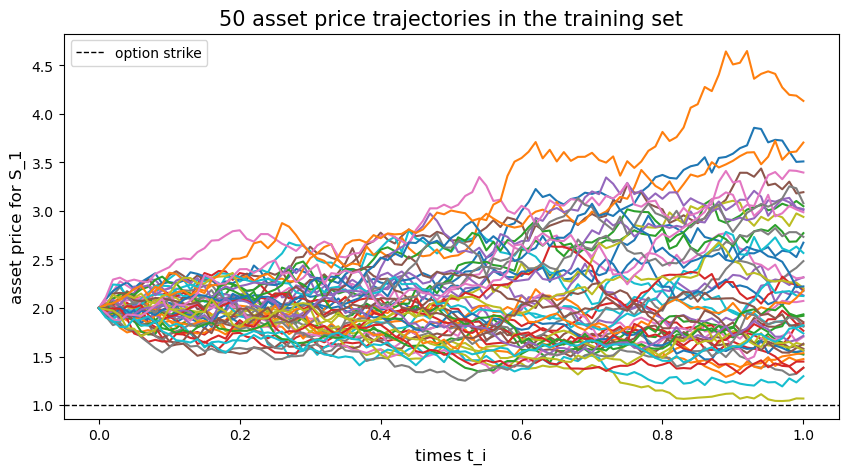

In [18]:
grid = [(i/N)*T for i in range(N+1)] # times t_0, t_1, ..., t_N = T
strike = 1
Delta_T = grid[i+1] - grid[i]

# Number of trajectories to plot
M = 50
asset_type = 1 # # choosing the asset to simulate (0 or 1)
S0_to_plot = S0[asset_type] 

# We select the log increments to plot
log_increments_to_plot = np.array(log_increments)[:, 0:M, asset_type]

traject_to_plot = S0_to_plot * np.exp( np.cumsum(log_increments_to_plot, axis=0) )

#Let us add the initial value S0 at time t_0, which is missing in the array above
traject_to_plot = np.concatenate( (S0_to_plot*np.ones((1,M)), traject_to_plot), axis=0)

plt.figure(figsize=(10,5))
plt.plot(grid, traject_to_plot)
plt.axhline(strike, linestyle='--', linewidth=1.0, color="k", label="option strike")

plt.title("%1.0f asset price trajectories in the training set" %M, fontsize=15)
plt.xlabel("times t_i", fontsize=12)
plt.ylabel(f"asset price for S_{asset_type}", fontsize=12)
plt.legend(loc="best")
plt.show()

# Part 2. Option Premium estimation using a Monte-Carlo simulation

In order to train the Neural Network, we need to estimate the actual option premium for the Exotic option on two assets following by the stohastic processes described above and a payoff
$$
g(S_{1T}, S_{2T}) = \left( \frac{S_{1T} S_{2T}}{S_{10} S_{20}} - 1 \right)^+
$$

However, we cannot use a Black-Scholes formula. Instead, we decided to make a separate Monte-Carlo simulation to estimate the option premium using the following formula:
$$
Price = E[g(S_{1T}, S_{2T})]
$$

In [19]:
# Number of time steps
N_Monte_Carlo = 100

# Covariance matrix based on correlation rho
C = np.array([[1, rho], [rho, 1]])

# Perform Cholesky decomposition of covariance matrix C
L = np.linalg.cholesky(C)

# Number of simulations
N_train_Monte_Carlo = 10**5

log_increments_monte_carlo = np.zeros((N_Monte_Carlo, N_train_Monte_Carlo, 2))

for i in range(N):
    Z = np.random.normal(size=(2, N_train_Monte_Carlo))
    G = L.dot(Z)
    
    # Calculate log increments for each process and store them in the combined array
    log_increments_monte_carlo[i, :, 0] = mu1 * Delta_T + sigma1 * np.sqrt(Delta_T) * G[0, :]
    log_increments_monte_carlo[i, :, 1] = mu2 * Delta_T + sigma2 * np.sqrt(Delta_T) * G[1, :]

In [20]:
# Simulation of the asset prices
S_T1 = S0[0] * np.exp(np.cumsum(log_increments_monte_carlo[:, :, 0], axis=0))
S_T2 = S0[1] * np.exp(np.cumsum(log_increments_monte_carlo[:, :, 1], axis=0))

# Estimation of the Option premium
g_ST = np.maximum((S_T1 * S_T2) / (S0[0] * S0[1]) - 1, 0)
premium_monte_carlo = np.mean(g_ST) * np.exp(-r * T)
print("Option premium according to Monte-Carlo Simulation:", premium_monte_carlo)

Option premium according to Monte-Carlo Simulation: 0.15189922615621282


# Part 3. Creation and Training of the NN Model

For each time $t$ of our model we apply a separate Neural Network with 3 layers including an output layer and 64 nodes per layer. The output of each NN is a tensor containing the values of $\delta_t^1$ and $\delta_t^2$ for the stohastic processes $S_t^1$ and $S_t^2$, which define the hedgining strategy at time $t$.

In [21]:
# Definition of the neural networks for the heding strategies

m = 2 # dimension of the asset price process
d = 3 # number of layers in the hedging strategy (including the output layer)
n = 64  # nodes in the first but last layers


# Architecture is the same for all networks (for all times t_i)

layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(units = nodes, activation='tanh', trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1), #kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(units = nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1), #kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [22]:
# Training Set
xtrain = ([S0 * np.ones((N_train, m))]  # asset price: same S_0 for all the trajectories
          + [np.zeros((N_train, m))]  # initial delta portion of the portfolio
          + [S0 * np.ones((N_train, m))]  # points over which the model can evaluate and output the hegding strategy (for plotting purposes)
          + [premium_monte_carlo * np.ones((N_train, m))] # input value for the option premium for each asset trajectory
          + [r_dt * np.ones((N_train, m))]
          + [np.zeros((N_train, m))]
          + log_increments)
# Concatenation of lists via the operator +

# ytrain is just zero everywhere
ytrain = np.zeros((N_train, 2))

We use the similar model architechture as we did in the Lab 6, however, we needed to make several adjustments to account for non-zero interest rate $r=0.04$. Sinse the resk free interest rate is non-zero the vaule of the hedging portfolio at time $t_{j+1}$ is define as:

$$
V_{tj+1} = V_{tj} + r \left( V_t - \sum_{k=1}^{2} \delta_{kt} S_{kt} \right) \Delta t + \sum_{k=1}^{2} \delta_{ktj} (S_{ktj+1} - S_{ktj}),
$$

Therefore we add separate variable total_interest and V_tj to account for the accumulated interest and the value of the hedgining portfolio at time $t_j$ repectively.

In [23]:
#########################################
# Construction of the deep hedging model
#########################################
# Inputs is the training set above
price = Input(shape=(m,)) # initial asset price
hedge = Input(shape=(m,)) # initial delta portion of the portfolio
hedge_eval = Input(shape=(m,)) # points over which the model can evaluate the hegding strategy, for output (plotting) purposes
premium = Input(shape=(m,)) # initial option price
risk_free_rate = Input(shape=(m,)) # initial option price
total_interest = Input(shape=(m,)) # accumulated interest

# Concatenation of lists
inputs = [price]+[hedge]+[hedge_eval]+[premium]+[risk_free_rate]+[total_interest]
output_helper = [] # this variable will allow us to output the final hedging strategy after training (for plotting purposes)

premium = Dense(units = 1, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),
                bias_initializer=initializers.RandomNormal(0,1))(premium)

V_tj = premium # value of the hedging portfolio at time t

for j in range(N):
    strategy = price
    strategy_eval = hedge_eval

    for k in range(d):
        strategy = layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at time t_j, i.e. the neural network h_j
        strategy_eval = layers[k+(j)*d](strategy_eval)
    
    incr = Input(shape=(m,)) # input variable: the single log-increment between t_j and t_{j+1} (dimension = m)
    inputs = inputs + [incr]

    # The instruction Lambda(lambda x : g(x)) wraps the function lambda into a layer object
    # Similarly, the instructions Add(), Subtract(), and Multiply() apply binary operations to layer objects
    logprice = Lambda(lambda x : K_backend.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew = Lambda(lambda x : K_backend.exp(x))(logprice) # creating the price at time j+1 by exponentiation
    priceincr = Subtract()([pricenew, price]) # the asset price increment S_{j+1} - S_j
    stock_portfolio = Multiply()([strategy, price])
    
    hedgenew = Multiply()([strategy, priceincr])
    hedge = Add()([hedge, hedgenew]) # building up the delta-hedging part of the portfolio
    
    cash_portfolio = Subtract()([V_tj, stock_portfolio]) # calculating the cash part of the portfolio
    interest = Multiply()([cash_portfolio, risk_free_rate]) # calculating the interest at time tj
    total_interest = Add()([total_interest, interest]) # calculating the accumulated interest
    
    V_tj = Add()([V_tj, interest])
    V_tj = Add()([V_tj, hedgenew])
    
    output_helper = output_helper + [strategy_eval]
    price = pricenew


payoff = Lambda( lambda x : K_backend.maximum((x[:, 0] * x[:, 1]) / (S0[0] * S0[1]) - 1, 0))(price)

outputs = Subtract()([payoff, hedge]) # substracting the delta hedging part
outputs = Subtract()([outputs, total_interest]) # substracting the accumulated interest part
outputs = Subtract()([outputs, premium]) # payoff minus delta hedge minus option premium


# This is the point where we construct the model output :
# hedging error + hedging strategy evaluated over the chosen points in the training set + option premium
outputs = [outputs] + output_helper + [premium]
outputs = Concatenate()(outputs)

#################################################################
# Note that our model contains all the different neural networks that
# implement the delta hedging strategy at the different times t_j
#################################################################
model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [24]:
def custom_loss(y_true, y_pred):
    ############################################################
    # Note we just use the first part of the model output
    # (that is to say, the payoff minus the total hedge).
    # This means there is no regularization included in this loss function.
    ############################################################
    z = y_pred[:, 0] - y_true[:, 0]
    z = K_backend.mean(K_backend.square(z))
    return z

In [25]:
model_hedge_strat.compile(optimizer='adam', loss=custom_loss)

In [26]:
model_hedge_strat.fit(x=xtrain, y=ytrain, epochs=5, verbose=True, batch_size=100)

In [ ]:
#Let us evaluate the model output over the training set
model_output = model_hedge_strat.predict(xtrain)

3125/3125 [==============================] - 13s 4ms/step


# Part 4. Model Evaluation

Let us evaluate the performance of the deep model: we display the histogram of the hedging error over the training set.
Recall that

$$
\text{Hedging error} = \text{Payoff} - (\text{Delta hedge} + \text{Accumulated Interest} + \text{Option premium})
$$

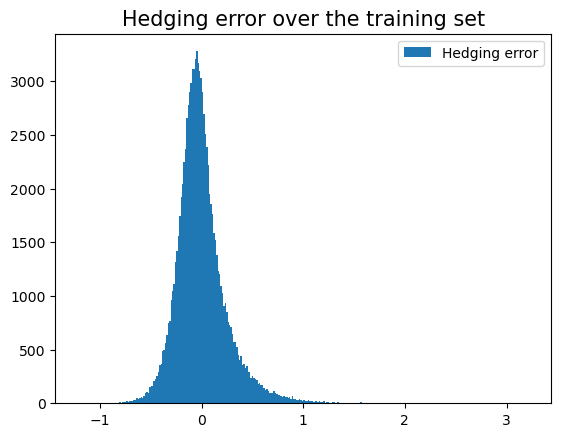

Hedging error sample average: -2.491e-03
Hedging error standard deviation: 2.510e-01 
 
Average option premium over the training set: 0.2156
Compare with the initial price according to the Monte-Carlo simulation : 0.1526 



In [ ]:
# Hedging error = payoff minus delta hedge minus option premium = the first variable in the model output
hedging_error = model_output[:, 0]
plt.hist(hedging_error, bins=int(np.sqrt(N_train)), label="Hedging error")
plt.title("Hedging error over the training set", fontsize=15)
plt.legend(loc="best")
plt.show()

print("Hedging error sample average: %1.3e" %np.mean(hedging_error))
print("Hedging error standard deviation: %1.3e \n " %np.std(hedging_error))

# Option price we obtained from the training = the last variable in the model output
output_option_premium = model_output[:, N+1]

print("Average option premium over the training set: %1.4f" %np.mean(output_option_premium))
print("Compare with the initial price according to the Monte-Carlo simulation : %1.4f \n" %premium_monte_carlo)

Now we will define the test set and display 2 deltas for the particular maturity on the test data

In [ ]:
N_test = 100

# points over which the model output evaluates the hedging strategy
hedge_eval_grid = S0 * np.linspace(0.5, 1.5, N_test).reshape(N_test, 1)

# Initialize an empty list for log increments
log_increments_test = []

for i in range(N):
    # Generate standard normal random variables for each time step
    Z = np.random.normal(size=(2, N_test))
    
    # Apply Cholesky decomposition to get correlated variables
    G = L.dot(Z)
    
    # Calculate log increments for each process and create a 2D array for this time step
    increments_t = np.zeros((N_test, 2))
    increments_t[:, 0] = mu1 * Delta_T + sigma1 * np.sqrt(Delta_T) * G[0, :]
    increments_t[:, 1] = mu2 * Delta_T + sigma2 * np.sqrt(Delta_T) * G[1, :]
    
    # Append the 2D array to the list
    log_increments_test.append(increments_t)

xtest = ([S0 * np.ones((N_test, m))]
         + [np.zeros((N_test, m))]  # initial values for the delta hedging part
         + [hedge_eval_grid]
         + [premium_monte_carlo * np.ones((N_test, m ))]# value for the option premium
         + [r_dt * np.ones((N_test, m))]
         + [np.zeros((N_test, m))]
         + log_increments_test)

4/4 [==============================] - 2s 4ms/step


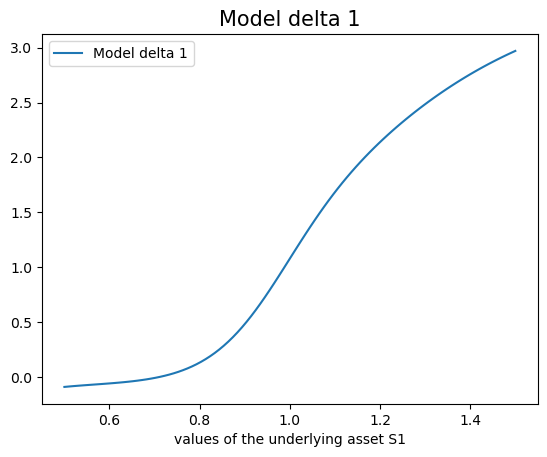

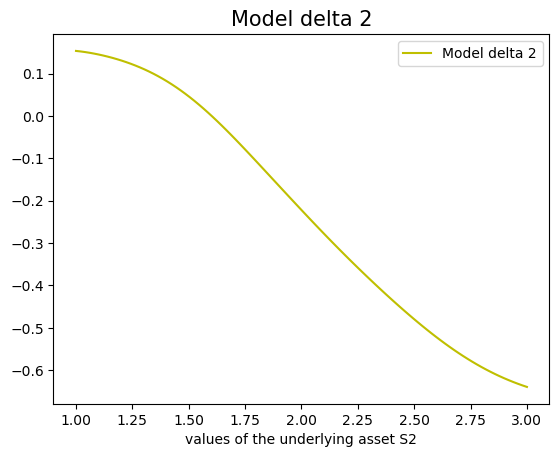

In [ ]:
# Let us choose a point on the grid of N time points t_j
time_point = 80

# The model delta
model_test = model_hedge_strat.predict(xtest)
model_delta_1 = model_test[:, (time_point * 2 - 1)  + 1]
model_delta_2 = model_test[:, (time_point * 2)  + 1]

# Watch out : we can select any l in {0,..., N-1}, but setting l=N would yield zero time to maturity tau=0. Also, in this case what does the deep model output ?

plt.plot(hedge_eval_grid[:, 0], model_delta_1, label="Model delta 1")

plt.xlabel("values of the underlying asset S1")
plt.title("Model delta 1", fontsize=15)
plt.legend(loc="best")
plt.show()

plt.plot(hedge_eval_grid[:, 1], model_delta_2, label="Model delta 2", color="y")

plt.xlabel("values of the underlying asset S2")
plt.title("Model delta 2", fontsize=15)
plt.legend(loc="best")
plt.show()